# Replicating and Experimenting Art Recognition Authenticy Evaluation Process

This code is not meant to be an exact copy of the how Art Recogition works, but it provides very similar results, which enable the audit and exploration of this type of approach to see if authenticity results are robust.


# Train Model

### Folder Structure for ImageFolder 'data'

data/  
├── authentic/  
│   ├── image1.png  
│   ├── image2.png  
│   ├── ...  
├── non_authentic/  
│   ├── image1.png  
│   ├── image2.png  
│   ├── ...  

In [ ]:
# Connect to Google Drive for 'data' directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from timm import create_model
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split

###################
# Set seeds for consistency in replication

SEED = 42

# Set seed for Python's random module
random.seed(SEED)

# Set seed for NumPy
np.random.seed(SEED)

# Set seed for PyTorch (CPU)
torch.manual_seed(SEED)

# Set seed for PyTorch (GPU) - CUDA
torch.cuda.manual_seed(SEED)

####################

# Recog CNN based on diagram
class RecogCNN(nn.Module):
    def __init__(self):
        super(RecogCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# SWIN Transformer
class SWINTransformer(nn.Module):
    def __init__(self):
        super(SWINTransformer, self).__init__()
        self.swin = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=1)

    def forward(self, x):
        x = self.swin(x)
        return x

# Combined Model
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.cnn = RecogCNN()
        self.swin = SWINTransformer()
        self.fusion = nn.Linear(2, 1)  # Fuse CNN and SWIN outputs

    def forward(self, x):
        cnn_output = self.cnn(x)
        swin_input = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        swin_output = self.swin(swin_input)
        combined_output = torch.cat((cnn_output, swin_output), dim=1)
        combined_output = self.fusion(combined_output)
        return torch.sigmoid(combined_output)

# Data Preprocessing with Patching
class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []
        for label, class_name in enumerate(os.listdir(root)):
            class_path = os.path.join(root, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.images.append((img_path, label))

    def __len__(self):
        return len(self.images)

    def create_patches(self, image):
        width, height = image.size
        patches = []
        if width > 1024 and height > 1024:
            patch_size = width // 5
            for i in range(5):
                for j in range(4):
                    patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
                    patches.append(patch)
        elif width > 512 and height > 512:
            patch_size = width // 2
            for i in range(2):
                for j in range(2):
                    patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
                    patches.append(patch)
        else:
            patches.append(image)
        return patches

    def __getitem__(self, index):
        img_path, label = self.images[index]
        image = Image.open(img_path).convert('RGB')
        patches = self.create_patches(image)
        processed_patches = []
        for patch in patches:
            if self.transform:
                patch = self.transform(patch)
            processed_patches.append(patch)
        return torch.stack(processed_patches), label

# Transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Load Dataset

dataset = PatchDataset('/content/drive/MyDrive/dataCezanne', transform=transform) #dataCezanne dataVanGogh
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)



# Training Strategy
def train_model(model, train_loader, val_loader, test_loader, epochs=2):
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.mean(dim=1))
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)


        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.mean(dim=1)).view(-1)  # Ensure correct shape
                labels = labels.float().view(-1)  # Ensure correct shape
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Test phase - Calculate test accuracy and F1 score
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.mean(dim=1)).view(-1)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_accuracy = 100 * correct / total
        test_f1 = f1_score(all_labels, all_preds)

        # Print training loss, validation loss, test accuracy, and test F1
        print(f"Epoch {epoch + 1}:")
        print(f"   Training Loss: {avg_train_loss:.4f}")
        print(f"   Validation Loss: {avg_val_loss:.4f}")
        print(f"   Test Accuracy: {test_accuracy:.2f}%")
        print(f"   Test F1 Score: {test_f1:.4f}")


# Initialize and Train Combined Model
combined_model = CombinedModel()
train_model(combined_model, train_loader, val_loader, test_loader)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1:
   Training Loss: 0.5183
   Validation Loss: 0.3202
   Test Accuracy: 88.00%
   Test F1 Score: 0.8421
Epoch 2:
   Training Loss: 0.3604
   Validation Loss: 0.2851
   Test Accuracy: 94.00%
   Test F1 Score: 0.9143


# Apply Model to New Image

In [ ]:
def apply_model(model, image_path, transform):
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    # Create patches based on size
    width, height = image.size
    patches = []
    if width > 1024 and height > 1024:
        patch_size = width // 5
        for i in range(5):
            for j in range(4):
                patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
                patches.append(transform(patch))
    elif width > 512 and height > 512:
        patch_size = width // 2
        for i in range(2):
            for j in range(2):
                patch = image.crop((j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size))
                patches.append(transform(patch))
    else:
        patches.append(transform(image))

    # Stack patches into a batch
    input_tensor = torch.stack(patches)

    # Pass through model and get confidence scores for each patch
    confidence_scores = []
    with torch.no_grad():
        for patch in input_tensor:
            output = model(patch.unsqueeze(0))  # Add batch dimension
            confidence = output.squeeze().item()
            confidence_scores.append(confidence)

    # Compute average and median scores
    # mean_score = sum(confidence_scores) / len(confidence_scores)
    median_score = sorted(confidence_scores)[len(confidence_scores) // 2]

    return median_score



In [ ]:
# Applying model to new image

import requests
from PIL import Image
from io import BytesIO
import pandas as pd


img = Image.open('/content/drive/MyDrive/Cezanne_Boy_In_A_Red_Vest_hires.jpg')  #Cezanne_Boy_In_A_Red_Vest_hires.jpg Elimar-painting-attributed-to-Vincent-van-Gogh_hires.png


# Create an empty dataframe to store results
results = []

# Loop over base_width from 1 to img.size[0]
# Define the desired width or height while keeping the aspect ratio
for size in range(1, img.size[0] + 1):
    print(f"{size} ", end='')
    if (size + 1) % 25 == 0:
        print()  # prints a newline
    base_width = size #img.size[0]
    w_percent = (base_width / float(img.size[0]))
    new_height = int((float(img.size[1]) * float(w_percent)))

    # Resize while maintaining aspect ratio
    resized_img = img.resize((base_width, new_height), Image.LANCZOS)

    # Save the image as PNG
    resized_img.save("Cezanne_Boy_in_a_Red_Vest.png", format="PNG") #"" Elimar-painting-attributed-to-Vincent-van-Gogh_hires.png
    # print(f"Resolution: {resized_img.size[0]} x {resized_img.size[1]}")

    image_path = 'Cezanne_Boy_in_a_Red_Vest.png' #"" Elimar-painting-attributed-to-Vincent-van-Gogh_hires.png
    results.append(apply_model(combined_model, image_path, transform))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 
75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 
125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 
175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 
225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 
250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 
2

In [ ]:
# Convert results to DataFrame
df = pd.DataFrame(results)

# Save the DataFrame to CSV
df.to_csv('median_scores_Cezanne.csv')

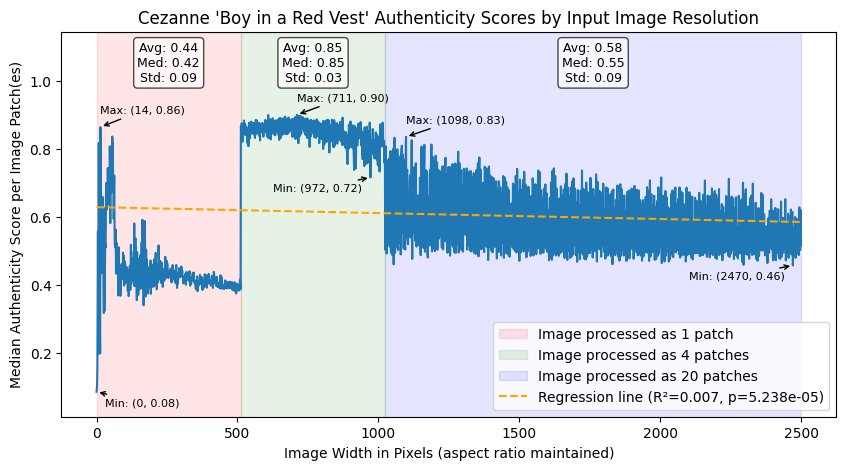

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

# Prepare the DataFrame
df = df.reset_index(drop=True)
df.columns = ["value"]
df["index"] = df.index

# Calculate y-axis limits with padding
y_min = df["value"].min()
y_max = df["value"].max()
y_range = y_max - y_min
padding = y_range * 0.3

# Plot the line chart
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="index", y="value")

# Define region boundaries
regions = [
    (0, 512, 'red', 'Image processed as 1 patch'),
    (512, 1024, 'green', 'Image processed as 4 patches'),
    (1024, df["index"].max(), 'blue', 'Image processed as 20 patches')
]

# Add shaded regions and annotations
for i, (start, end, color, label) in enumerate(regions):
    plt.axvspan(start, end, color=color, alpha=0.1, label=label)

    region_df = df[(df["index"] >= start) & (df["index"] < end)]

    # Get max and min points
    max_point = region_df.loc[region_df["value"].idxmax()]
    min_point = region_df.loc[region_df["value"].idxmin()]

    # Annotate max point (above)
    plt.annotate(
        f'Max: ({int(max_point["index"])}, {max_point["value"]:.2f})',
        xy=(max_point["index"], max_point["value"]),
        xytext=(max_point["index"], max_point["value"] + y_range * 0.05),
        arrowprops=dict(arrowstyle='->', color='black'),
        fontsize=8
    )

    # Annotate min point
    if i == 0:
        # Region 1: right and down
        xytext = (min_point["index"] + 30, min_point["value"] - y_range * 0.05)
        ha = 'left'
    else:
        # Regions 2 & 3: left and down
        xytext = (min_point["index"] - 30, min_point["value"] - y_range * 0.05)
        ha = 'right'

    plt.annotate(
        f'Min: ({int(min_point["index"])}, {min_point["value"]:.2f})',
        xy=(min_point["index"], min_point["value"]),
        xytext=xytext,
        arrowprops=dict(arrowstyle='->', color='black'),
        fontsize=8,
        ha=ha
    )

    # Average, Median, and Standard Deviation
    avg_val = region_df["value"].mean()
    median_val = region_df["value"].median()
    std_val = region_df["value"].std()
    mid_x = (start + end) / 2
    stat_y = y_max + y_range * 0.11

    plt.text(
        mid_x, stat_y,
        f'Avg: {avg_val:.2f}\nMed: {median_val:.2f}\nStd: {std_val:.2f}',
        ha='center', va='bottom',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

# Set y-limits to ensure visibility
plt.ylim(y_min - padding * 0.3, y_max + padding)

# Final touches
plt.title("Cezanne 'Boy in a Red Vest' Authenticity Scores by Input Image Resolution")
plt.xlabel("Image Width in Pixels (aspect ratio maintained)")
plt.ylabel("Median Authenticity Score per Image Patch(es)")


# Fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(df["index"], df["value"])
regression_line = intercept + slope * df["index"]

# Plot the regression line
plt.plot(df["index"], regression_line, color='orange', linestyle='--',
         label=f'Regression line (R²={r_value**2:.3f}, p={p_value:.3e})')


plt.legend()
plt.savefig("Cezanne_BoyInARedVest_authenticity_scores_by_resolution_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # reset df for adjustments to visualization
# df = pd.DataFrame(results)

# # Prepare the DataFrame
# df = df.reset_index(drop=True)
# df.columns = ["value"]
# df["index"] = df.index


# # Calculate y-axis limits with padding
# y_min = df["value"].min()
# y_max = df["value"].max()
# y_range = y_max - y_min
# padding = y_range * 0.2  # 20% padding


# # Plot the line chart
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=df, x="index", y="value")

# # Define region boundaries
# regions = [
#     (0, 512, 'red', 'Image processed as 1 patch'),
#     (512, 1024, 'green', 'Image processed as 4 patches'),
#     (1024, df["index"].max(), 'blue', 'Image processed as 20 patches')
# ]

# # Add shaded regions and annotations
# for start, end, color, label in regions:
#     plt.axvspan(start, end, color=color, alpha=0.1, label=label)

#     # Extract region data
#     region_df = df[(df["index"] >= start) & (df["index"] < end)]

#     # Get max and min points
#     max_point = region_df.loc[region_df["value"].idxmax()]
#     min_point = region_df.loc[region_df["value"].idxmin()]


#     # Annotate max point
#     plt.annotate(
#         f'Max: ({int(max_point["index"])}, {max_point["value"]:.2f})',
#         xy=(max_point["index"], max_point["value"]),
#         xytext=(max_point["index"], max_point["value"] + y_range * 0.05),
#         arrowprops=dict(arrowstyle='->', color='black'),
#         fontsize=8
#     )

#     # Annotate min point (adjust based on region)
#     if start >= 512:
#         # For 2nd and 3rd regions: down and to the left
#         xytext = (min_point["index"] - 200, min_point["value"] - y_range * 0.2)
#     else:
#         # For 1st region: just downward
#         xytext = (min_point["index"], min_point["value"] - y_range * 0.2)

#     plt.annotate(
#         f'Min: ({int(min_point["index"])}, {min_point["value"]:.2f})',
#         xy=(min_point["index"], min_point["value"]),
#         xytext=xytext,
#         arrowprops=dict(arrowstyle='->', color='black'),
#         fontsize=8
#     )


#     # Average, Median, and Standard Deviation
#     avg_val = region_df["value"].mean()
#     median_val = region_df["value"].median()
#     std_val = region_df["value"].std()
#     mid_x = (start + end) / 2
#     stat_y = y_max + y_range * -0.05  # place above the line

#     # Annotate stat box
#     plt.text(
#         mid_x, stat_y,
#         f'Avg: {avg_val:.2f}\nMed: {median_val:.2f}\nStd: {std_val:.2f}',
#         ha='center', va='bottom',
#         fontsize=9,
#         bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
#     )

# # Set y-limits with padding to ensure all labels fit
# plt.ylim(.5 - padding * 0.3, y_max + padding)

# # Add titles and labels
# plt.title("Elimar Van Gogh Authenticity Scores by Input Image Resolution")
# plt.xlabel("Image Width in Pixels (aspect ratio maintained)")
# plt.ylabel("Median Authenticity Score per Image Patch(es)")


# # Fit regression line
# from scipy.stats import linregress

# slope, intercept, r_value, p_value, std_err = linregress(df["index"], df["value"])
# regression_line = intercept + slope * df["index"]

# # Plot the regression line
# plt.plot(df["index"], regression_line, color='orange', linestyle='--',
#          label=f'Regression line (R²={r_value**2:.3f}, p={p_value:.3e})')

# plt.legend()

# plt.savefig("Elimar_Van_Gogh_authenticity_scores_by_resolution_plot.png", dpi=300, bbox_inches='tight')
# plt.show()
